Starting training...
Epoch: 010, Loss: 0.5510, Train Acc: 0.7750, Test Acc: 0.5500
Epoch: 020, Loss: 0.4905, Train Acc: 0.7688, Test Acc: 0.5750
Epoch: 030, Loss: 0.3827, Train Acc: 0.8938, Test Acc: 0.8000
Epoch: 040, Loss: 0.2762, Train Acc: 0.9313, Test Acc: 0.7500
Epoch: 050, Loss: 0.1602, Train Acc: 0.9625, Test Acc: 0.8750
Epoch: 060, Loss: 0.0938, Train Acc: 0.9875, Test Acc: 0.8500
Epoch: 070, Loss: 0.1297, Train Acc: 0.9875, Test Acc: 0.9250
Epoch: 080, Loss: 0.0606, Train Acc: 1.0000, Test Acc: 0.9500
Epoch: 090, Loss: 0.0112, Train Acc: 1.0000, Test Acc: 0.9500
Epoch: 100, Loss: 0.0092, Train Acc: 1.0000, Test Acc: 0.9500

Training completed!


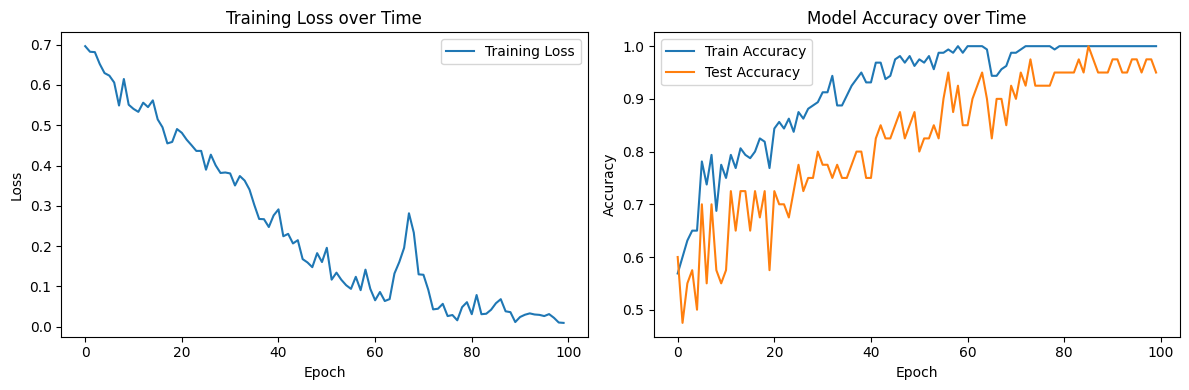


Evaluating on test set...


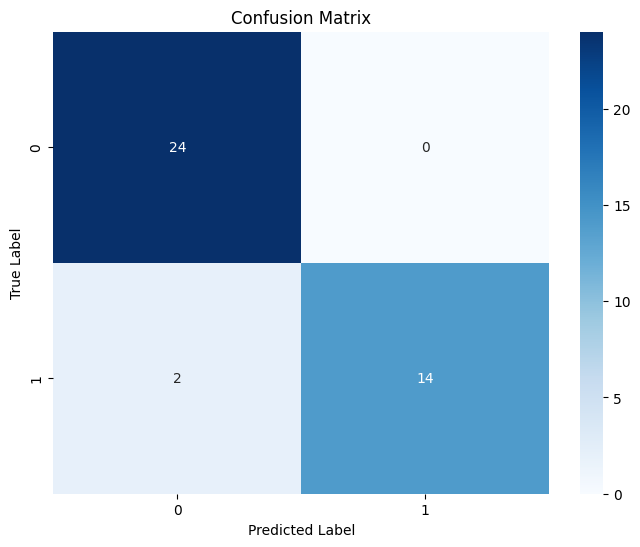

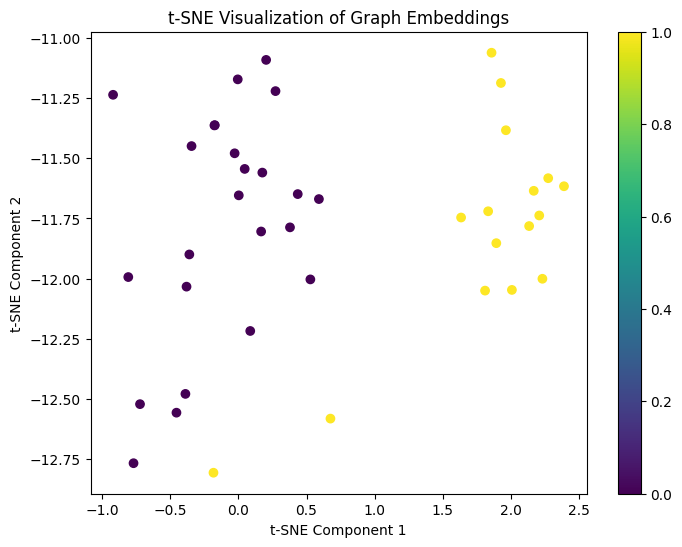


Classification Report:
              precision    recall  f1-score   support

       Cycle       0.92      1.00      0.96        24
        Star       1.00      0.88      0.93        16

    accuracy                           0.95        40
   macro avg       0.96      0.94      0.95        40
weighted avg       0.95      0.95      0.95        40



In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import networkx as nx

# [Previous SyntheticGraphDataset and GCN classes remain the same]
class SyntheticGraphDataset(Dataset):
    def __init__(self, num_graphs=200):
        super().__init__()
        self.num_graphs = num_graphs
        self.graphs = []
        self._generate_graphs()

    def _generate_graphs(self):
        for i in range(self.num_graphs):
            if i < self.num_graphs // 2:
                # Generate cycle-like graphs
                num_nodes = np.random.randint(6, 10)
                edge_index = []
                for j in range(num_nodes):
                    edge_index.extend([[j, (j + 1) % num_nodes], 
                                     [(j + 1) % num_nodes, j]])
                label = 0
            else:
                # Generate star-like graphs
                num_nodes = np.random.randint(6, 10)
                edge_index = []
                for j in range(1, num_nodes):
                    edge_index.extend([[0, j], [j, 0]])
                label = 1

            x = torch.randn(num_nodes, 3)
            edge_index = torch.tensor(edge_index, dtype=torch.long).t()
            y = torch.tensor([label], dtype=torch.long)
            
            data = Data(x=x, edge_index=edge_index, y=y)
            self.graphs.append(data)

    def len(self):
        return self.num_graphs

    def get(self, idx):
        return self.graphs[idx]

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)
        self.graph_embeddings = x  # Store embeddings for visualization
        x = self.lin(x)
        return x

# Visualization functions
def plot_training_history(train_losses, train_accs, test_accs):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_graph_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Graph Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

def visualize_example_graphs():
    # Create example graphs
    plt.figure(figsize=(12, 5))
    
    # Cycle graph
    plt.subplot(1, 2, 1)
    G_cycle = nx.cycle_graph(6)
    nx.draw(G_cycle, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=16, font_weight='bold')
    plt.title('Example Cycle Graph (Class 0)')
    
    # Star graph
    plt.subplot(1, 2, 2)
    G_star = nx.star_graph(5)
    nx.draw(G_star, with_labels=True, node_color='lightgreen',
            node_size=500, font_size=16, font_weight='bold')
    plt.title('Example Star Graph (Class 1)')
    
    plt.tight_layout()
    plt.show()

# [Previous imports and dataset class remain the same]

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += len(data.y)
    return float(correct) / total  # Return accuracy as float

def predict_and_evaluate(model, loader, device):
    model.eval()
    predictions = []
    true_labels = []
    embeddings = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(data.y.cpu().numpy())
            embeddings.extend(model.graph_embeddings.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels), np.array(embeddings)

def main():
    # Create and split dataset
    dataset = SyntheticGraphDataset(num_graphs=200)
    torch.manual_seed(12345)
    dataset = dataset.shuffle()
    train_dataset = dataset[:160]
    test_dataset = dataset[160:]
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(num_node_features=3, hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training history
    train_losses = []
    train_accs = []
    test_accs = []
    
    # Training loop
    print("Starting training...")
    for epoch in range(100):
        # Training
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Evaluation
        train_acc = evaluate(model, train_loader, device)
        test_acc = evaluate(model, test_loader, device)
        
        # Store metrics
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {total_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    print("\nTraining completed!")
    
    # Plot training history
    plot_training_history(train_losses, train_accs, test_accs)
    
    # Make predictions on test set
    print("\nEvaluating on test set...")
    y_pred, y_true, embeddings = predict_and_evaluate(model, test_loader, device)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)
    
    # Plot graph embeddings
    plot_graph_embeddings(embeddings, y_true)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Cycle', 'Star']))

if __name__ == '__main__':
    main()